# Estimation of Molecular Diffusivity
#### Data Driven Physics based model solved numerically using SciPy

In [1]:
# Import Libraires
import numpy as np
import numpy.polynomial.chebyshev as cheb
import pandas as pd
import scipy.optimize as scopt
import scipy.integrate as scint
import matplotlib.pyplot as plt
import numba
import os
import openpyxl as xl

#### Initializing State Vectors from Meta Data located in a seperate Excel File

In [6]:
# Number of nodes for descritization
N      = 10

# Number of Experiments conducted
trials = 14 
runs   = np.arange(trials)

# Location of Meta data
path = os.getcwd() + r"\\data\\daData_20220629_MVPdata.xlsx"
srcfile= xl.load_workbook(path, read_only=False)

#### Data aquisition, cleaning and generating new features

In [55]:
#%% Preprocessing
listdata = {}
for run in runs:
    
    # Collecting available data from experiments
    T = pd.read_excel(path, sheet_name='T')[run+1].dropna() + 273.16 # (Units = Kelvin)
    H = pd.read_excel(path, sheet_name='H')[run+1].dropna()          # (Units = %)
    V = pd.read_excel(path, sheet_name='V')[run+1].dropna()          # (Units = m/s)
    W = pd.read_excel(path, sheet_name='W')[run+1].dropna()          # (Units = grams)
    MC = pd.read_excel(path, sheet_name='MC')[run+1].dropna()        # (Units = kg/kg)
    
    # Collecting Meta Data
    Ngrapes  = int(srcfile['I'].cell(row = 5, column = run+3).value) # (Units = Nos)
    Wt_dym   = srcfile['I'].cell(row = 7, column = run+3).value      # (Units = grams)
    t = np.arange(len(T)) * 3600
    Wt_wat_i = W[0] - Wt_dym #kg 
    
    # Assumptions
    MW_wat   = 18.0     #g/mol
    rho_drm  = 0.001540 #g/mm3 density of raisin matrix
    rho_wat  = 0.001000 #g/mm3 density of raisin water
    vL = MW_wat/rho_wat #mm3/mol
    
    # Data Cleaning using Regression
    print(f"Regressing Data for run {run+1}")
    def get_T(t, f, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12):
        cos = np.cos
        ft = f*t
        T = a0 + a11*t + a12*t**2
        T += a1*cos(  ft+ a10) + a2*cos(2*ft+ a10) + a3*cos(3*ft+ a10)
        T += a4*cos(4*ft+ a10) + a5*cos(5*ft+ a10) + a6*cos(6*ft+ a10)
        T += a7*cos(7*ft+ a10) + a8*cos(8*ft+ a10) + a9*cos(9*ft+ a10)
        return T;
    p0T = 2*np.pi*1e-5, 313, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    pT, perrT = scopt.curve_fit(get_T, t, T, p0 = p0T);
    
    # Generating co-eff for Humidity as a function of time
    def get_RH(t, coeffs):
        RH = cheb.chebval(t, coeffs);
        return RH;
    pRH = cheb.chebfit(t, H, 40);
                       
    # Dumping data in to list
    listdata[run] = {"T":pT, 
                     "RH":pRH, 
                     "Ngrapes":Ngrapes, 
                     "Mmatrix":Wt_dym, 
                     "Mwater0":Wt_wat_i, 
                     "velocity":V[0],
                     "MCsmooth":MC,
                     "t":t}

Regressing Data for run 1
Regressing Data for run 2
Regressing Data for run 3
Regressing Data for run 4
Regressing Data for run 5
Regressing Data for run 6
Regressing Data for run 7
Regressing Data for run 8
Regressing Data for run 9
Regressing Data for run 10
Regressing Data for run 11
Regressing Data for run 12
Regressing Data for run 13
Regressing Data for run 14


##### Temperature and Humidity profiles for experiments

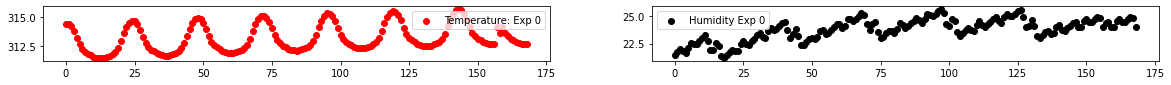

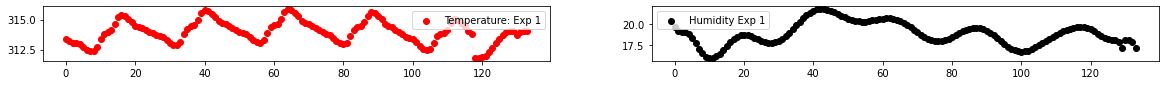

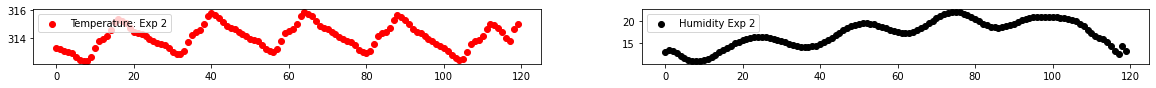

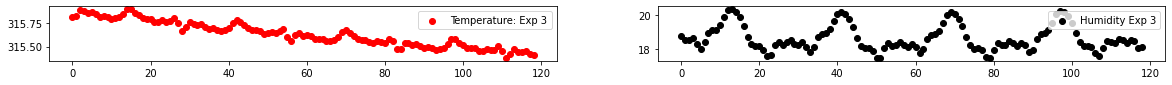

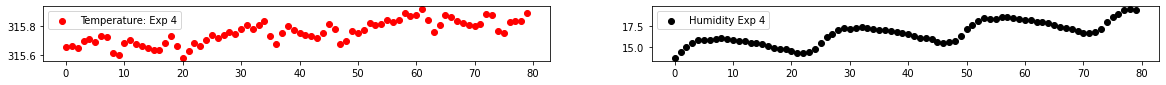

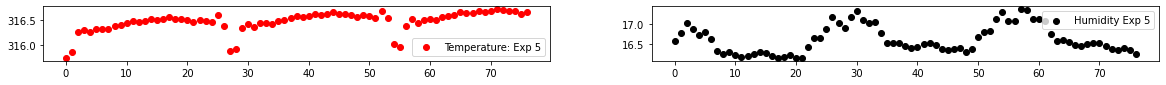

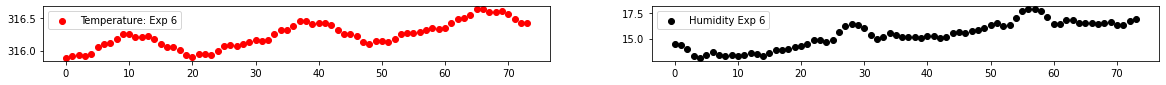

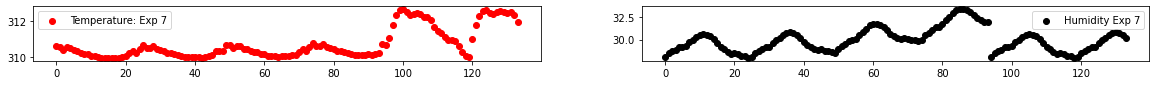

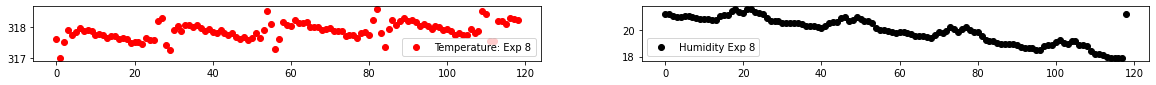

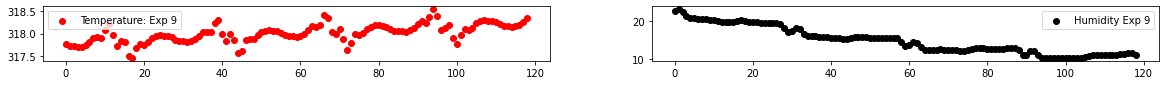

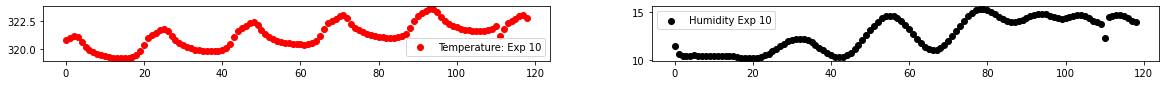

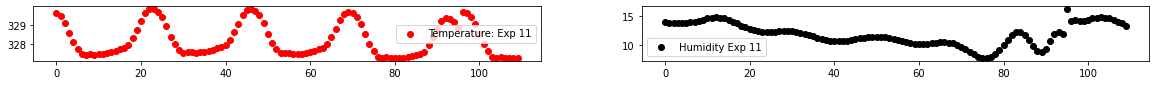

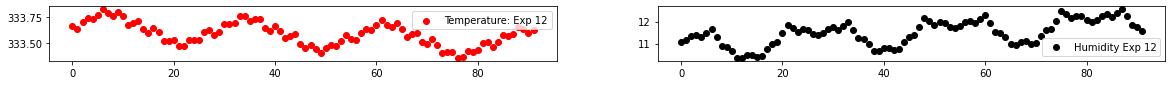

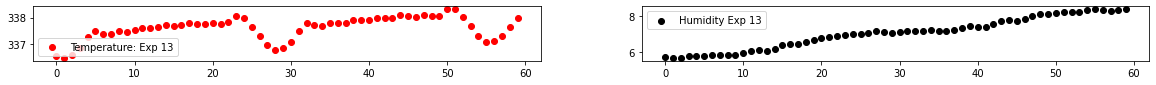

In [52]:
for i in runs:
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 1), constrained_layout=False)
        ax1.scatter(np.arange(len(pd.read_excel(path, sheet_name='T')[i+1].dropna() + 273.16)),
                pd.read_excel(path, sheet_name='T')[i+1].dropna() + 273.16,
                label=f'Temperature: Exp {i}',
                color = 'r',
                marker = 'o'
                )
        ax1.legend();  
        ax2.scatter(np.arange(len(pd.read_excel(path, sheet_name='H')[i+1].dropna())),
                pd.read_excel(path, sheet_name='H')[i+1].dropna(),
                label=f'Humidity Exp {i}',
                color = 'k',
                marker = 'o'
                );           
        ax2.legend();    

#### User Defined Functions used in models

In [56]:
#%% Functions
@numba.jit(nopython = True)
def P_sat(T): #P in bar T in K
    return 10**(5.20389-1733.926/(T-39.485))

@numba.jit(nopython = True)
def get_xL(C, vL, vR):
    xL = C/(C + (1 - C*vL)/vR)
    return xL

@numba.jit(nopython = True)   
def get_lngammaL(xL, aLR, aRL, alpha):
    xR = 1-xL
    tauLR = aLR
    tauRL = aRL
    GLR = np.exp(-alpha*tauLR)
    GRL = np.exp(-alpha*tauRL)
    
    Term1 = tauRL*GRL**2/(xL + xR*GRL)**2 
    Term2 = tauLR*GLR   /(xL*GLR + xR)**2
    
    return xR**2*(Term1 + Term2)

@numba.jit(nopython = True)
def get_dlngammabydxL(xL, aLR, aRL, alpha):
    dxL = 1e-9
    lngammaL = get_lngammaL(xL, aLR, aRL, alpha)
    lngammaLplus = get_lngammaL(xL + dxL, aLR, aRL, alpha)
    return (lngammaLplus - lngammaL)/dxL

@numba.jit(nopython = True)
def get_dMbydt(dMbydt, M, Mm, NL, C, r, delr, D, vL, vR, N, aLR, aRL, alpha):
    fourpiby3 = 4*np.pi/3.0
    onethird = 1.0/3.0
    
    for i in range(N):
        V = (M[i]*vL + Mm[i]*vR)
        ri = r[i]
        C[i] = M[i]/V     
        Vip = V + fourpiby3*ri**3 
        rip = (Vip/fourpiby3)**onethird 
        dr = rip - ri
        r[i+1] = rip
        delr[i] = dr 
    
    for i in range(1,N):
        if M[i] < 0:
            print(i, M[i])
        xi = M[i]/(M[i]+Mm[i]); xim = M[i-1]/(M[i-1]+Mm[i-1])
        xborder = xim + (xi - xim)*delr[i-1]/(delr[i-1] + delr[i])
        gamma = 1 + xborder * get_dlngammabydxL(xborder, aLR, aRL, alpha)
        dCbydr = 2*(C[i] - C[i-1])/(delr[i] + delr[i-1])
        NL[i] = -D*dCbydr*gamma/(1-xborder)
    
    for i in range(N):
        dMbydt[i] = 4*np.pi*((r[i]**2)*NL[i] - (r[i+1]**2)*NL[i+1])
    
    return dMbydt
        
@numba.jit(nopython = True)
def get_MandMm(M, Mm, delr, N, C0, Cm):
    ri = 0.0
    for i in range(N):
        rip = ri + delr
        V = 4*np.pi/3*(rip**3 - ri**3)
        M[i] = V*C0
        Mm[i] = V*Cm
        
        ri = rip + 0.0
    return M, Mm

##### Model Based on Maxwell Stefans Approach

In [57]:
# Model: Diffusion of water from core to surface to air
def model(t, M, pRH, pT, Mm, kg, Do, TD, mwR, alpha, aLR, aRL):
    
    N = len(M)
    
    T = get_T(t, *pT)
    D = Do*np.exp(-TD/T)
    vR = mwR/rho_drm
    Psat = P_sat(T)
    RH = get_RH(t, pRH)
    Pw = RH*Psat/100

    
    xsurf = M[-1]/(M[-1] + Mm[-1])

    PL = np.exp(get_lngammaL(xsurf, aLR, aRL, alpha))*xsurf*Psat
    
    Pdrv = PL - Pw
    print(t, Pdrv)
    
    dMbydt = np.zeros(N)
    
    C = np.zeros(N)
    
    NL = np.zeros(N+1)
    NL[0]  =  0.0
    NL[N]  =  kg*Pdrv
    
    r = np.zeros(N+1)
    delr = np.zeros(N)
    
    dMbydt = get_dMbydt(dMbydt, M, Mm, NL, C, r, delr, D, vL, vR, N, aLR, aRL, alpha)

    return dMbydt

#### Solver

In [60]:
#%% Solver: Discritization, shell balance
def solve(data, kg, Do, TD, mwR, alpha, aLR, aRL):
    t = data["t"] + 0.0
    tend = t[-1]
    
    Mwater0 = data["Mwater0"]
    Mmatrix = data["Mmatrix"]
    Ngrapes = data["Ngrapes"]
    
    vR = mwR/rho_drm
    
    Q0 = Mwater0/Ngrapes/MW_wat
    Qm = Mmatrix/Ngrapes/mwR
    
    V0 = Q0*vL + Qm*vR
    R  = (3/(4*np.pi)*V0)**(1.0/3.0)
    
    delr = R/N
    
    C0 = Q0/V0
    Cm = Qm/V0
    
    Mm = np.zeros(N)
    M  = np.zeros(N)
    
    M, Mm = get_MandMm(M, Mm, delr, N, C0, Cm) 
   
    sol = scint.solve_ivp(model, [0, tend], M, 
                          args=(data["RH"], data["T"], Mm, kg, Do, TD, mwR, alpha, aLR, aRL),
                          dense_output = True, method = 'DOP853')#'LSODA')
    
    solution = sol.sol(t).transpose()

    #print(f"nfev {sol.nfev} njev {sol.njev} nlu {sol.nlu}")
    
    def get_Mwater(row):
        return np.sum(np.array(row))*MW_wat
    
    labels = [f"C{i}" for i in range(N)]
    df = pd.DataFrame(solution, columns = labels)
    df["Mwater"] = df.apply(get_Mwater, axis = 1)
    
    df_sol = pd.DataFrame({
            "t":t,
            "Ccore":solution[:,1],
            "Csurf":solution[:,-1],
            "Weight":np.array(df["Mwater"])*data["Ngrapes"] + data["Mmatrix"],
            
            })

    return df_sol

#### Optimization Function by reducing Sum of Squared Errors

In [58]:
#%% Residual calculation
def residuals(parameters):
    print('Parameters')#,parameters) 
    parameters = [abs(params) for params in parameters]#[:-2]] + list(parameters[-2:])
    [Do, TD, mwR, alpha, aLR, aRL] = parameters[len(runs):]
    listkg = parameters[:len(runs)] 
    print("kg    :", listkg)
    print("TD    :", TD)
    print("mwR   :", mwR)
    print("alpha :", alpha)
    print("aLR   :", aLR)
    print("aRL   :", aRL)
    
    errors = []
    for irun in runs:
        kg = listkg[irun]
        data = listdata[irun]
        
        df_sol = solve(data, kg*1e-9, Do*1e-9, TD, mwR, alpha, aLR, aRL)
        MCsol = (df_sol["Weight"] - data["Mmatrix"])/df_sol["Weight"]
        error = list((MCsol - data["MCsmooth"])/data["MCsmooth"])
        
        """ 
        #Experimenal noisy data points (Not used here)
        MC = (data["df"]["Weight"] - data["Mmatrix"])/data["df"]["Weight"]
        error = list((MCsol - MC))
        """
        """
        # Comparison plots (Not used here)
        plot_comparison(df_sol, data)
        """
        errors += error
    
    # Sum of squared error
    SSE = sum(np.array(errors)**2)  
    print('SSE', SSE)   
    return errors

In [ ]:
#%% Optimization function

# Initial Guesses
mwR   = 29.60e0
Do    = 62.00e7
TD    = 28.83e2
alpha = 17.92e-3
aLR   = 23.04e-3
aRL   = 54.90e-2

listkg = [ 8.77, 11.00, 12.01, 12.99, 14.04,
          16.00, 16.95,	14.65, 12.99, 10.99,
           9.09,  8.00,  6.50,	5.99 ]

# Solver: minimizes residuals, optimizes MTCs, Do, TD, mwR, alpha, aLR, aRL
plsq = scopt.least_squares(residuals, listkg + [Do, TD, mwR, alpha, aLR, aRL])

In [ ]:
#%% Solution & Plots: obtained from fitted parameters, and dumped in excel sheet
for run in runs:
    kg     = listkg[run]
    df_sol = solve(listdata[run], kg*1e-9, Do*1e-9, TD, mwR, alpha, aLR, aRL)
    
    srcfile   = xl.load_workbook(path, read_only=False)   
    for i in range(len(df_sol)):
        srcfile['Sol'].cell(row = (i+2), column = run+2).value = df_sol["Weight"][i]
        srcfile['Sim'].cell(row = (i+2), column = run+2).value = df_sol["Weight"][i]/max(df_sol["Weight"])   
    srcfile['I'].cell(row = (24), column = 6).value = Do
    srcfile['I'].cell(row = (25), column = 6).value = TD
    srcfile['I'].cell(row = (26), column = 6).value = mwR
    srcfile['I'].cell(row = (27), column = 6).value = alpha
    srcfile['I'].cell(row = (28), column = 6).value = aLR
    srcfile['I'].cell(row = (29), column = 6).value = aRL    
    srcfile.save(path);   


#### Validation

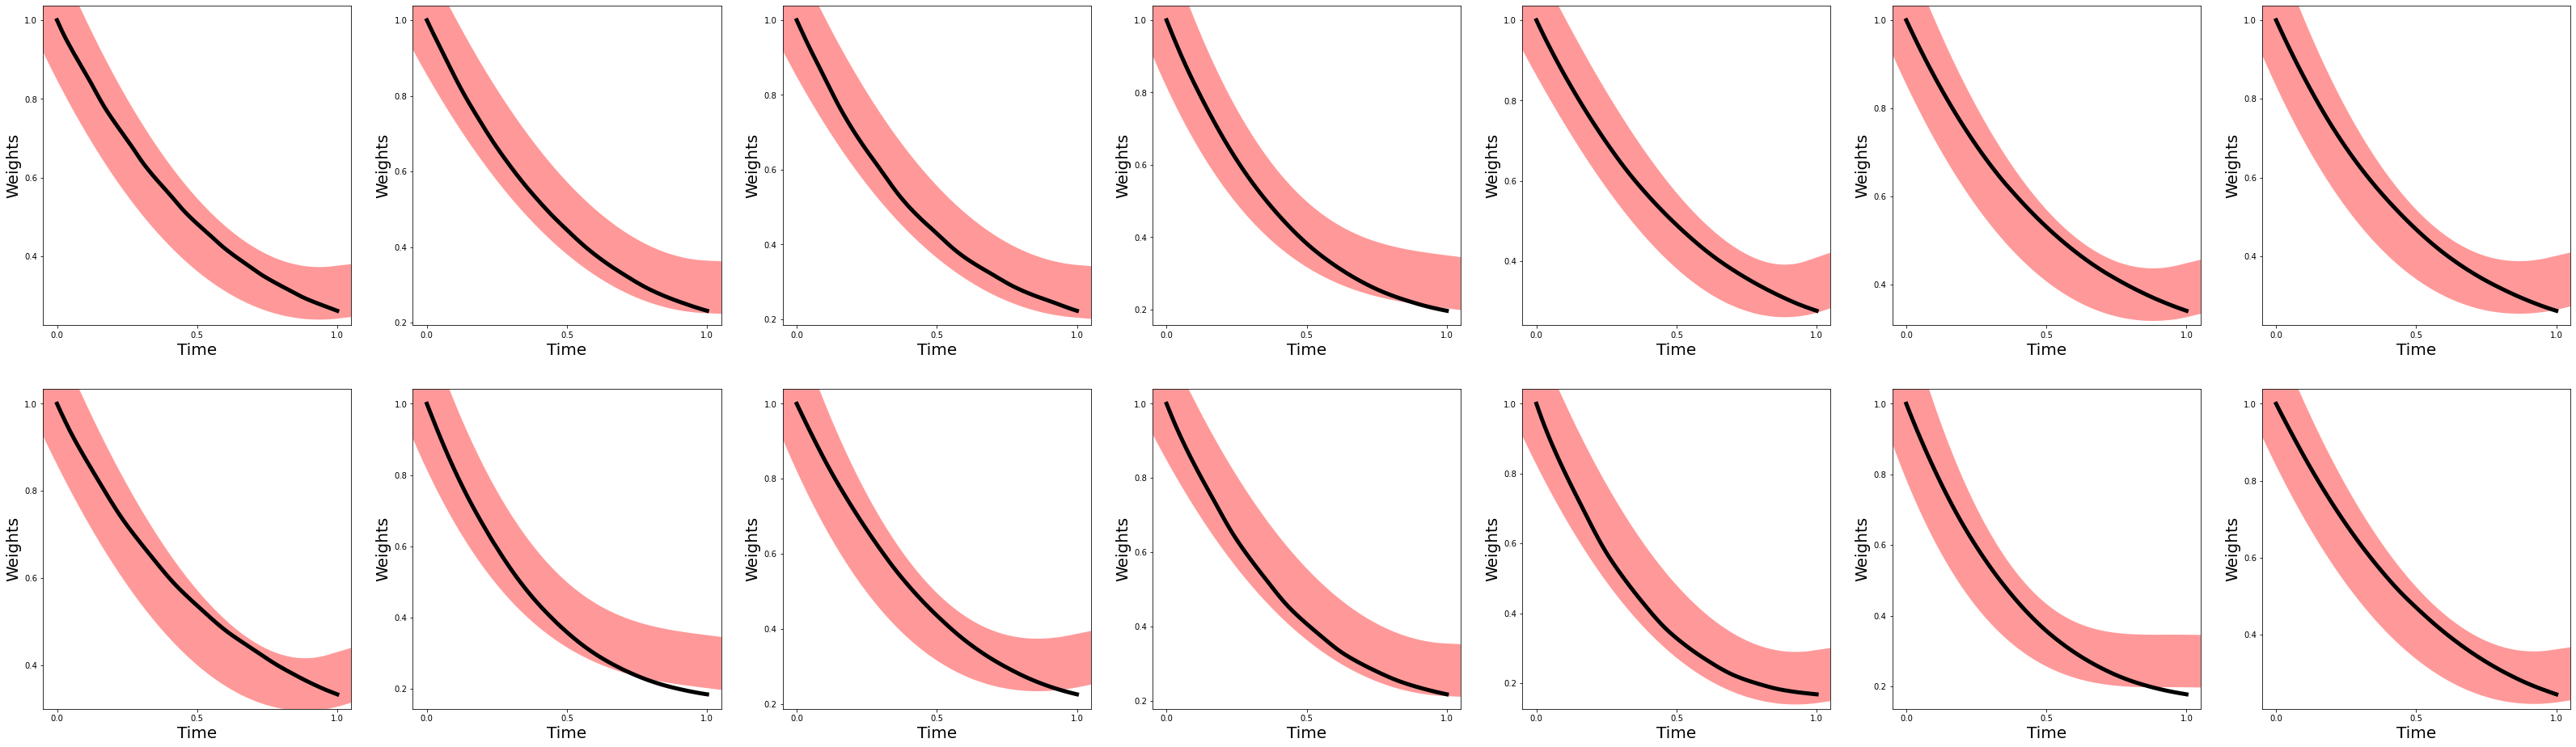

In [67]:
# Comparison Plots
Wexp = pd.read_excel(path, sheet_name='Exp')
Wsim = pd.read_excel(path, sheet_name='Sim')
t = np.linspace(0,299,300)

fits, axs = plt.subplots(ncols=7, nrows=2, figsize=(56, 16))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)

for ax, i in zip(axs.flat, runs):
    
    lim = len(Wsim[i+1].dropna())
    hours = t[:lim] / t[:lim].max()
    ax.plot(hours[:lim], Wexp[i+1].dropna()[:lim], 'r-', lw = 65, alpha = 0.4)
    ax.plot(hours[:lim], Wsim[i+1].dropna()[:lim], 'k-', lw =  5)
    ax.set_xlabel('Time', fontsize = 20)
    ax.set_ylabel('Weights', fontsize = 20)